In [1]:
import os
import random
import warnings
from sklearn.model_selection import KFold

import cv2
import numpy as np
import pandas as pd
import sklearn.metrics
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensorV2
from os import environ
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import socket

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append("../..")

In [3]:
from utils.csvlogger import *
from utils.radam import *

#from utils.arguments.train_arguments import *
from models import *
from utils.training import *

In [4]:
sz = 224
bs = 4

nfolds = 4  # keep the same split as the initial dataset
fold = 0
SEED = 2019

if environ.get('BENGALI_DATA_PATH') is not None:
    INPUT_PATH = environ.get('BENGALI_DATA_PATH')
    TRAIN_IMGS = "grapheme-imgs"
    LABELS = INPUT_PATH + "/train.csv"
else:
    assert False, "Please set the environment variable BENGALI_DATA_PATH. Read the README!"

df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]

stats = ([0.0692], [0.2051])

# Data

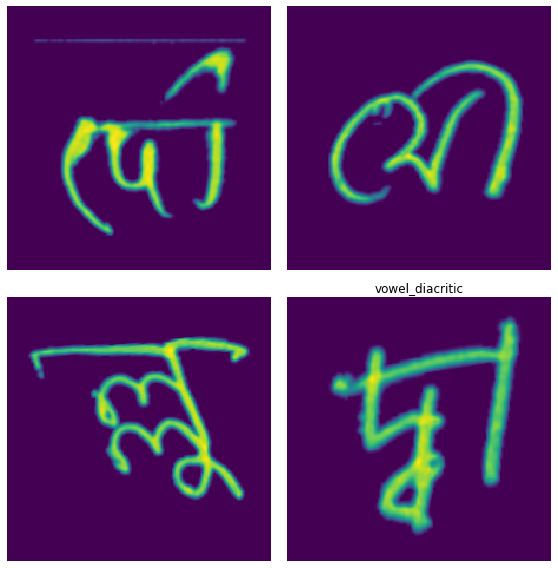

In [5]:
seed_everything(SEED)
data = (ImageList.from_df(df, path=INPUT_PATH, folder=TRAIN_IMGS, suffix='.png', 
          cols='image_id', convert_mode='L')
        .split_by_idx(range(fold * len(df) // nfolds, (fold + 1) * len(df) // nfolds))
        .label_from_df(cols=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])
        .transform(data_augmentation_selector("None"), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)
data.show_batch()

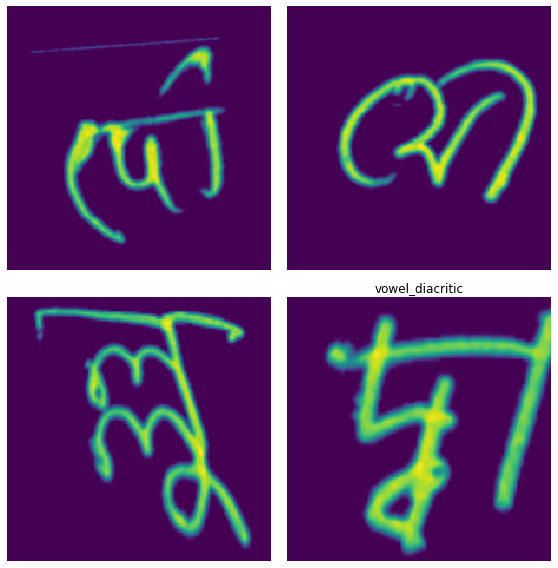

In [6]:
seed_everything(SEED)
data = (ImageList.from_df(df, path=INPUT_PATH, folder=TRAIN_IMGS, suffix='.png', 
          cols='image_id', convert_mode='L')
        .split_by_idx(range(fold * len(df) // nfolds, (fold + 1) * len(df) // nfolds))
        .label_from_df(cols=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])
        .transform(data_augmentation_selector("da4"), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)
data.show_batch()

In [7]:
def customDA():
    additional_aug = [*
        zoom_crop(scale=(0.85, 1.15), do_rand=True),
        cutout(n_holes=(1, 2), length=(32, 84), p=.5),
        brightness(change=(0.33, 0.68), p=.5),
        contrast(scale=(0.7, 1.4), p=.5),
        squish(scale=(0.8, 1.2), p=.5),
    ]
    return get_transforms(do_flip=False, max_warp=0.25, max_zoom=1.25, max_rotate=17, xtra_tfms=additional_aug)

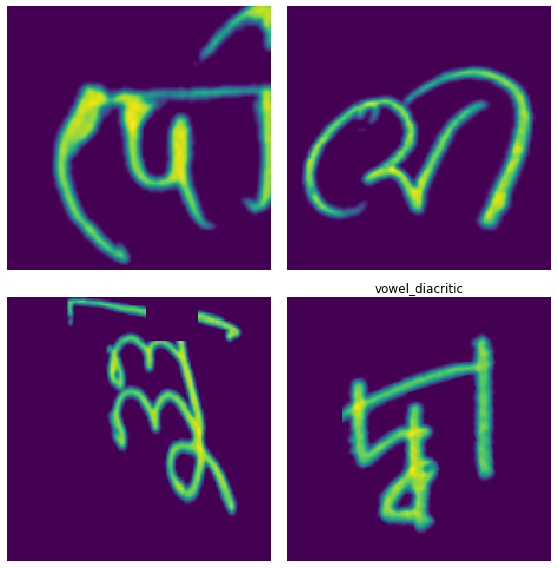

In [8]:
seed_everything(SEED)

data = (ImageList.from_df(df, path=INPUT_PATH, folder=TRAIN_IMGS, suffix='.png', 
          cols='image_id', convert_mode='L')
        .split_by_idx(range(fold * len(df) // nfolds, (fold + 1) * len(df) // nfolds))
        .label_from_df(cols=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])
        .transform(customDA(), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

data.show_batch()